In [7]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [24]:
df=pd.read_csv('./data/USvideos.csv',sep=',')

df=df[df.dislikes > 0]
df=df[df.likes > 0]

In [9]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,24583.000000,2.458300e+04,2.458300e+04,2.458300e+04,2.458300e+04
mean,20.102835,1.337824e+06,4.768864e+04,2.857406e+03,6.040797e+03
std,7.576760,4.137650e+06,1.512231e+05,3.475924e+04,3.244700e+04
min,1.000000,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00
25%,17.000000,1.334130e+05,2.841500e+03,1.230000e+02,3.750000e+02
50%,24.000000,3.868000e+05,1.107100e+04,3.920000e+02,1.205000e+03
75%,25.000000,1.133778e+06,3.331800e+04,1.255500e+03,3.706500e+03
max,43.000000,1.493761e+08,3.093544e+06,1.674420e+06,1.361580e+06


In [10]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


# Popularity metrics

Since most of the raw features like (views, likes, dislikes, comment_count) has very large variance and should be highly correlated to the channel. So it should be very difficult to predict the features in interest from other features. In order to compensate for the effect, we try to define our own metrics on 'popularity'.

In [11]:
df["likes_per_views"]=df["likes"]/df["views"]
df["likes_to_dislikes"]=df["likes"]/df["dislikes"]
df["log_likes_per_views"]=np.log(df["likes"]/df["views"])
df["log_likes_to_dislikes"]=np.log(df["likes"]/df["dislikes"])


Text(0.5,1,'log_likes_to_dislikes')

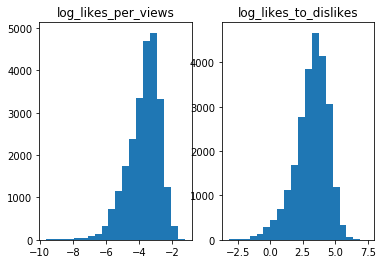

In [20]:
fig,axs=plt.subplots(1,2)
axs[0].hist(df["log_likes_per_views"],bins=20)
axs[1].hist(df["log_likes_to_dislikes"],bins=20)
axs[0].set_title("log_likes_per_views")
axs[1].set_title("log_likes_to_dislikes")

# Channels

In [13]:
print("number of unique channel: ",df['channel_title'].value_counts().shape[0])

number of unique channel:  1892


In [14]:
counts=df['channel_title'].value_counts() 
channel_list=counts[counts > 10].index.tolist()
counts

ESPN                                       122
Vox                                        121
NBA                                        120
Netflix                                    120
First We Feast                             119
The Tonight Show Starring Jimmy Fallon     117
NFL                                        115
Tom Scott                                  114
TheEllenShow                               112
The Late Show with Stephen Colbert         111
WWE                                        109
Life Noggin                                107
INSIDER                                    106
Jimmy Kimmel Live                          105
Late Night with Seth Meyers                105
Screen Junkies                             104
CNN                                        104
Saturday Night Live                         96
Great Big Story                             94
Marques Brownlee                            92
WIRED                                       92
Refinery29   

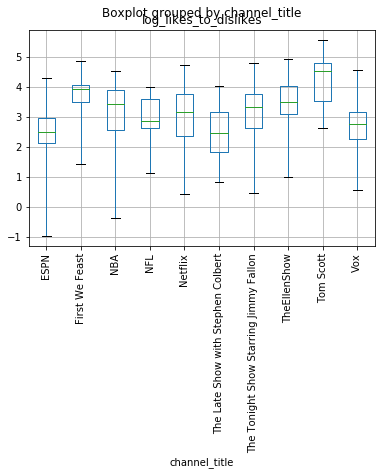

In [15]:
df[df['channel_title'].isin(channel_list[:10])].boxplot(
    column=["log_likes_to_dislikes"],by='channel_title',whis=10,rot=90)

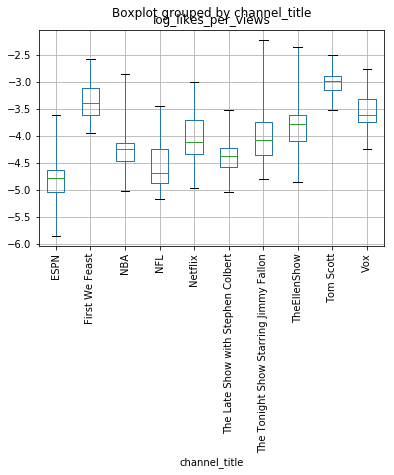

In [16]:
df[df['channel_title'].isin(channel_list[:10])].boxplot(
    column=["log_likes_per_views"],by='channel_title',whis=10,rot=90)

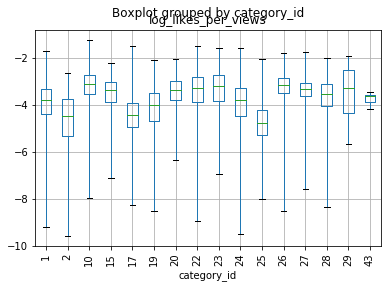

In [17]:
df.boxplot(
    column=["log_likes_per_views"],by='category_id',whis=10,rot=90)

# Descriptions

Text(0.5,1,'Number of words in the description')

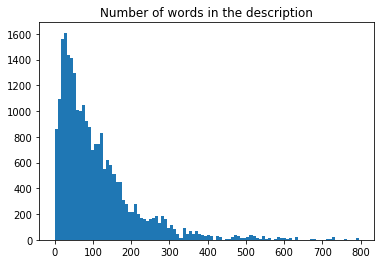

In [28]:
lengths = [len(str(s).split()) for s in df["description"]]

plt.hist(lengths, bins=100)
plt.title('Number of words in the description')

In [29]:
sum(lengths) / len(lengths)

109.03392588374079

# Channel titles

Text(0.5,1,'Number of words in the channel title')

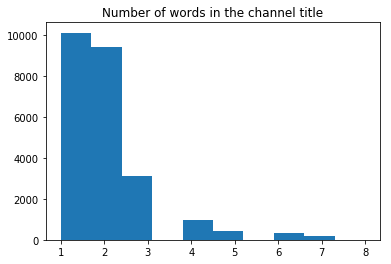

In [31]:
lengths = [len(str(s).split()) for s in df['channel_title']]

plt.hist(lengths)
plt.title('Number of words in the channel title')

In [32]:
sum(lengths) / len(lengths)

1.9453687507627222

# Correlations between features

[Text(0,0,''),
 Text(0,0,'views'),
 Text(0,0,'likes'),
 Text(0,0,'dislikes'),
 Text(0,0,'comment_count'),
 Text(0,0,'likes_to_dislikes'),
 Text(0,0,'likes_per_views')]

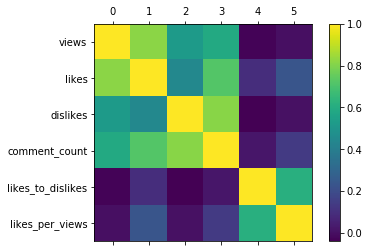

In [18]:
features=['views','likes','dislikes','comment_count','likes_to_dislikes','likes_per_views']
df_cov=df[features]

fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(df_cov.corr())
fig.colorbar(cax)
ax.set_yticklabels(['']+features)